# Import

In [ ]:
!pip install geodatasets

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler, LabelEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer

import joblib

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CHURN PROJECT/Databel - Data.csv')

# Data preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6687 entries, 0 to 6686
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        6687 non-null   object 
 1   Churn Label                        6687 non-null   object 
 2   Account Length (in months)         6687 non-null   int64  
 3   Local Calls                        6687 non-null   int64  
 4   Local Mins                         6687 non-null   float64
 5   Intl Calls                         6687 non-null   float64
 6   Intl Mins                          6687 non-null   float64
 7   Intl Active                        6687 non-null   object 
 8   Intl Plan                          6687 non-null   object 
 9   Extra International Charges        6687 non-null   float64
 10  Customer Service Calls             6687 non-null   int64  
 11  Avg Monthly GB Download            6687 non-null   int64

In [ ]:
df['Churn Reason'].unique()

array([nan, 'Competitor made better offer', 'Moved',
       'Competitor had better devices',
       'Competitor offered higher download speeds',
       'Attitude of support person', 'Network reliability', "Don't know",
       'Service dissatisfaction', 'Product dissatisfaction',
       'Poor expertise of online support', 'Price too high',
       'Limited range of services',
       'Lack of affordable download/upload speed',
       'Long distance charges', 'Competitor offered more data',
       'Attitude of service provider', 'Poor expertise of phone support',
       'Extra data charges', 'Deceased',
       'Lack of self-service on Website'], dtype=object)

In [ ]:
df['Churn Category'].unique()

array([nan, 'Competitor', 'Other', 'Attitude', 'Dissatisfaction', 'Price'],
      dtype=object)

In [ ]:
df.head(10)

,Customer ID,Churn Label,Account Length (in months),Local Calls,Local Mins,Intl Calls,Intl Mins,Intl Active,Intl Plan,Extra International Charges,Customer Service Calls,Avg Monthly GB Download,Unlimited Data Plan,Extra Data Charges,State,Phone Number,Gender,Age,Under 30,Senior,Group,Number of Customers in Group,Device Protection & Online Backup,Contract Type,Payment Method,Monthly Charge,Total Charges,Churn Category,Churn Reason
0,4444-BZPU,No,1,3,8.0,0.0,0.0,No,no,0.0,0,3,Yes,0,KS,382-4657,Female,35,No,No,No,0,No,Month-to-Month,Direct Debit,10,10,NaN,NaN
1,5676-PTZX,No,33,179,431.3,0.0,0.0,No,no,0.0,0,3,Yes,0,OH,371-7191,Male,49,No,No,No,0,Yes,One Year,Paper Check,21,703,NaN,NaN
2,8532-ZEKQ,No,44,82,217.6,0.0,0.0,No,yes,0.0,0,3,Yes,0,OH,375-9999,Male,51,No,No,No,0,Yes,One Year,Direct Debit,23,1014,NaN,NaN
3,1314-SMPJ,No,10,47,111.6,60.0,71.0,Yes,yes,0.0,0,2,Yes,0,MO,329-9001,Female,41,No,No,No,0,No,Month-to-Month,Paper Check,17,177,NaN,NaN
4,2956-TXCJ,No,62,184,621.2,310.0,694.4,Yes,yes,0.0,0,3,Yes,0,WV,330-8173,Male,51,No,No,No,0,No,One Year,Direct Debit,28,1720,NaN,NaN
5,9152-DEPY,No,17,68,120.7,0.0,0.0,No,no,0.0,0,0,No,0,RI,344-9403,Male,23,Yes,No,No,0,No,Two Year,Credit Card,9,156,NaN,NaN
6,1958-SDSO,No,57,428,849.2,0.0,0.0,No,no,0.0,0,5,Yes,0,IA,363-1107,Male,38,No,No,No,0,Yes,One Year,Credit Card,47,2671,NaN,NaN
7,8787-QZUC,No,25,54,203.7,0.0,0.0,No,no,0.0,0,12,Yes,0,IA,366-9238,Male,29,Yes,No,No,0,Yes,Month-to-Month,Direct Debit,47,1197,NaN,NaN
8,7768-OQJE,No,70,171,627.4,0.0,0.0,No,no,0.0,0,1,Yes,0,NY,351-7269,Female,47,No,No,No,0,Yes,Two Year,Credit Card,52,3593,NaN,NaN
9,7716-RHEB,No,50,206,445.8,0.0,0.0,No,no,0.0,0,0,No,0,ID,350-8884,Female,61,No,No,No,0,No,One Year,Paper Check,11,539,NaN,NaN


In [ ]:
df.loc[(df['Churn Label'] == 'No') & (df['Churn Category'].isnull()), 'Churn Category'] = "Other"
df.loc[(df['Churn Label'] == 'No') & (df['Churn Reason'].isnull()), 'Churn Reason'] = "Don't know"

# Exploratory Data Analysis

## Churn Overview:

In [ ]:
print(f"Churn Rate overall: {len(df[df['Churn Label'] == 'Yes']) / len(df) * 100:.2f}%")

Churn Rate overall: 26.86%


In [ ]:
print(f"Total charges: {df['Total Charges'].sum():,.2f}$")

Total charges: 7,247,074.00$


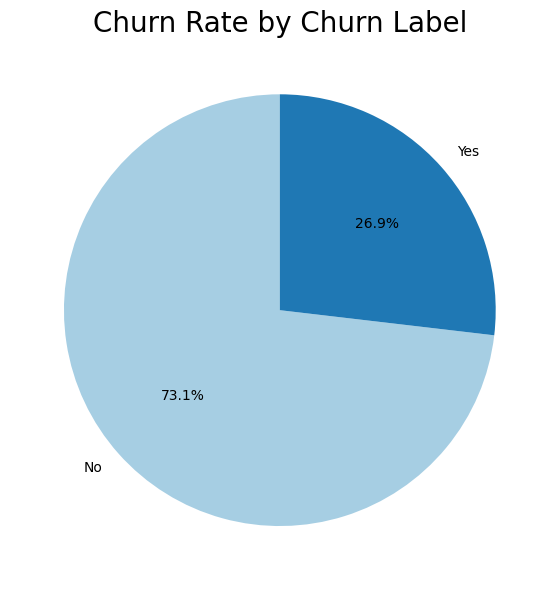

In [ ]:
churn_label_counts = df['Churn Label'].value_counts()
total_customers = len(df)
churn_rate_by_label = (churn_label_counts / total_customers) * 100

plt.figure(figsize=(6, 6))
plt.pie(
    churn_rate_by_label,
    labels=churn_rate_by_label.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors
)
plt.title('Churn Rate by Churn Label', fontsize=16)
plt.tight_layout()
plt.show()

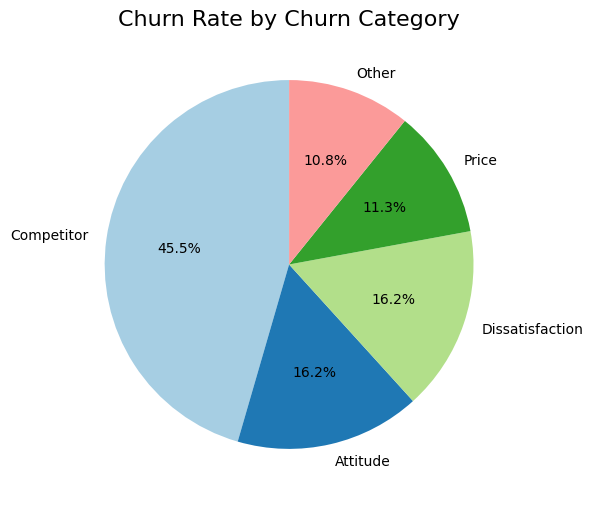

In [ ]:
churn_data = df[df['Churn Label'] == 'Yes'].copy()
churn_category_counts = churn_data['Churn Category'].value_counts()
total_customers = len(df)
churn_rate_by_category = (churn_category_counts / total_customers) * 100

plt.figure(figsize=(6, 6))
plt.pie(
    churn_rate_by_category,
    labels=churn_rate_by_category.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors
)
plt.title('Churn Rate by Churn Category', fontsize=16)
plt.tight_layout()
plt.show()

<ipython-input-23-67045f6d257f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


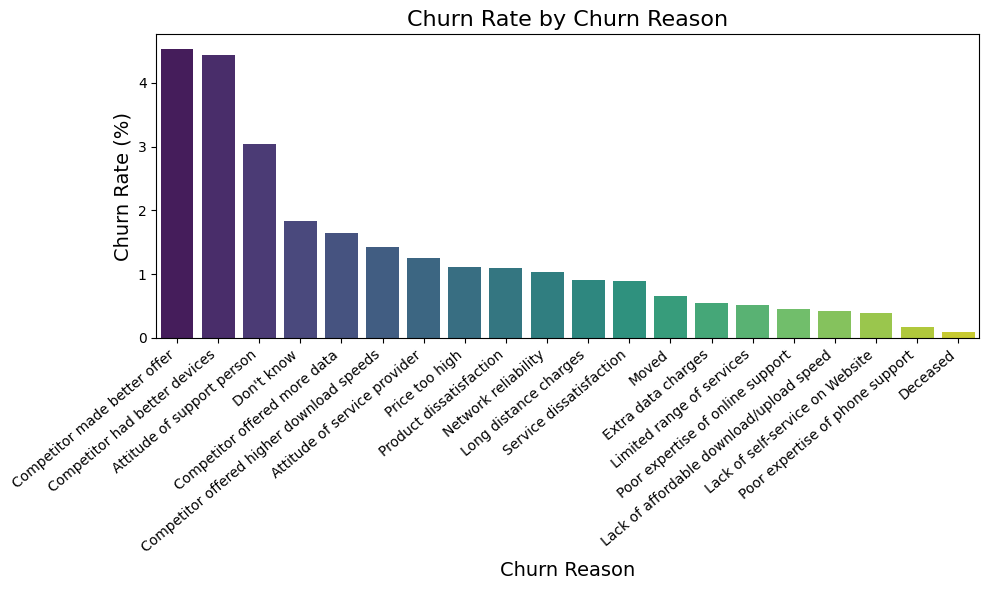

In [ ]:
churn_data = df[df['Churn Label'] == 'Yes'].copy()
churn_reason_counts = churn_data['Churn Reason'].value_counts()
total_customers = len(df)
churn_rate_by_reason = (churn_reason_counts / total_customers) * 100

plt.figure(figsize=(10, 6))
sns.barplot(
    x=churn_rate_by_reason.index,
    y=churn_rate_by_reason.values,
    palette="viridis"
)
plt.title('Churn Rate by Churn Reason', fontsize=16)
plt.xlabel('Churn Reason', fontsize=14)
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.xticks(rotation=40, ha='right')
plt.tight_layout()
plt.show()

<ipython-input-24-c0ba44627909>:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['centroid'] = merged.geometry.centroid


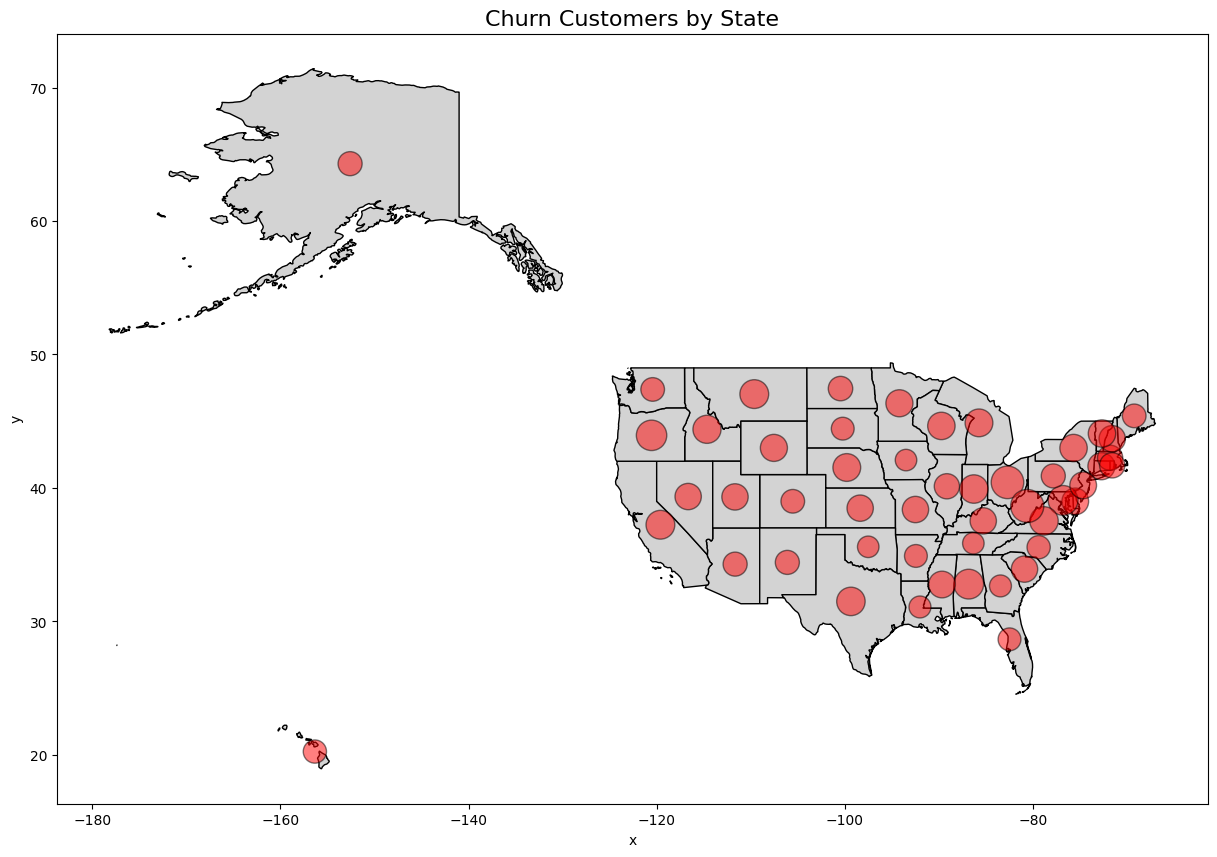

In [ ]:
# Load US states shapefile
url = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces.zip"
usa_states = gpd.read_file(url)

# Filter for USA state
usa_states = usa_states[usa_states['admin'] == 'United States of America']


churn_data = df[df['Churn Label'] == 'Yes'].copy()  # Filter churned customers
state_abbr_to_full = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado',
    'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
    'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Map the state abbreviations to full state names in the churn data
churn_data['full_state_name'] = churn_data['State'].map(state_abbr_to_full)
churn_reason_counts = pd.DataFrame(churn_data['full_state_name'].value_counts())

# Merge churn data with the states shapefile
merged = usa_states.set_index('name').join(churn_reason_counts)
merged['centroid'] = merged.geometry.centroid
merged['x'] = merged['centroid'].x
merged['y'] = merged['centroid'].y

# Plot the map with bubbles
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the map with bubbles based on churn_count
merged.plot(ax=ax, color='lightgray', edgecolor='black')
merged.plot(ax=ax, kind='scatter', x='x', y='y',
            s=merged['count']*10,  # Scale the bubble size
            color='red', alpha=0.5, edgecolor='black', linewidth=1)

plt.title('Churn Customers by State', fontsize=16)
plt.show()

## Churn by Customer Demographics and Payment

In [ ]:
print(f"Average monthly charges overall is: {df['Monthly Charge'].mean():,.2f}$")

Average monthly charges overall is: 31.03$


In [ ]:
print(f"Average monthly charges of churned customers is: {df[df['Churn Label'] == 'Yes']['Monthly Charge'].mean():,.2f}$")

Average monthly charges of churned customers is: 36.80$


In [ ]:
print(f"Total charges of churned customers is: {df[df['Churn Label'] == 'Yes']['Total Charges'].sum():,.2f}$")

Total charges of churned customers is: 1,367,515.00$


<ipython-input-29-ab4847ccf17c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate_by_gender.index, y=churn_rate_by_gender['Churn Rate'], palette='Blues')


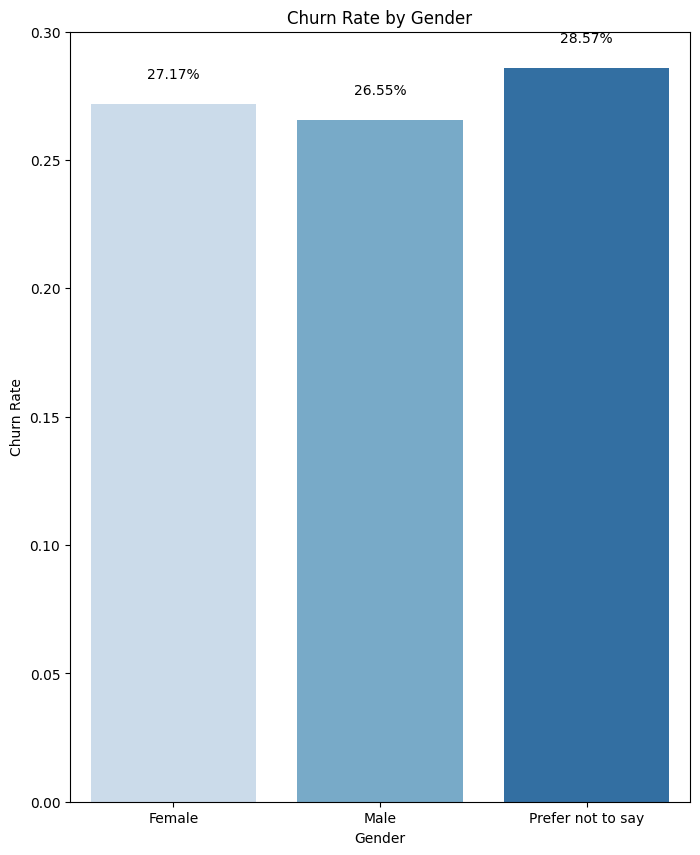

In [ ]:
# Calculate churn rate by gender
churn_rate_by_gender = df.groupby('Gender')['Churn Label'].value_counts(normalize=True).unstack().fillna(0)
churn_rate_by_gender['Churn Rate'] = churn_rate_by_gender['Yes']

# Plot the churn rate by gender as a column chart
plt.figure(figsize=(8, 10))
sns.barplot(x=churn_rate_by_gender.index, y=churn_rate_by_gender['Churn Rate'], palette='Blues')

for index, value in enumerate(churn_rate_by_gender['Churn Rate']):
    plt.text(index, value + 0.01, f"{value:.2%}", ha='center', fontsize=10)

# Add titles and labels
plt.title('Churn Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Churn Rate')
plt.show()

<ipython-input-30-7c841a672343>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate_by_pm.index, y=churn_rate_by_pm['Churn Rate'], palette='Blues')


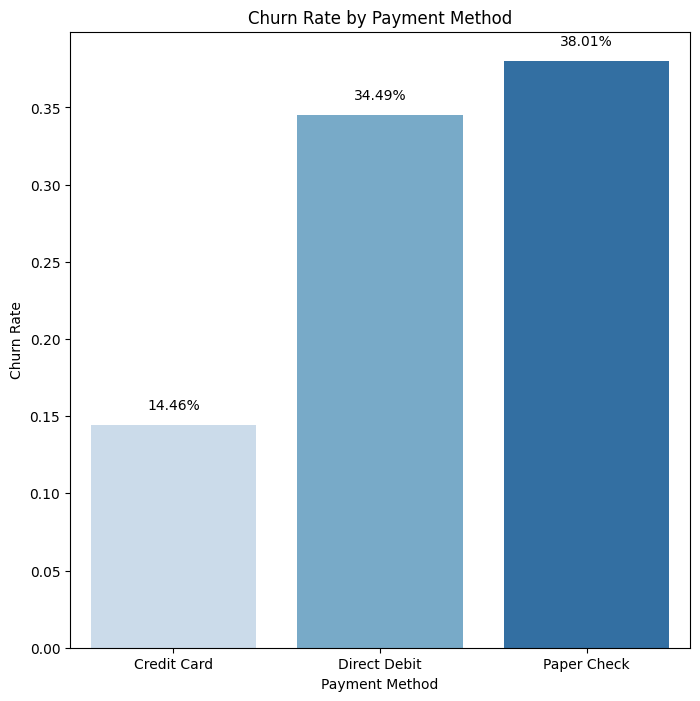

In [ ]:
churn_rate_by_pm = df.groupby('Payment Method')['Churn Label'].value_counts(normalize=True).unstack().fillna(0)
churn_rate_by_pm['Churn Rate'] = churn_rate_by_pm['Yes']

plt.figure(figsize=(8, 8))
sns.barplot(x=churn_rate_by_pm.index, y=churn_rate_by_pm['Churn Rate'], palette='Blues')

for index, value in enumerate(churn_rate_by_pm['Churn Rate']):
    plt.text(index, value + 0.01, f"{value:.2%}", ha='center', fontsize=10)

plt.title('Churn Rate by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Churn Rate')
plt.show()

<ipython-input-31-6e4107f60f4e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate_by_ct.index, y=churn_rate_by_ct['Churn Rate'], palette='Blues')


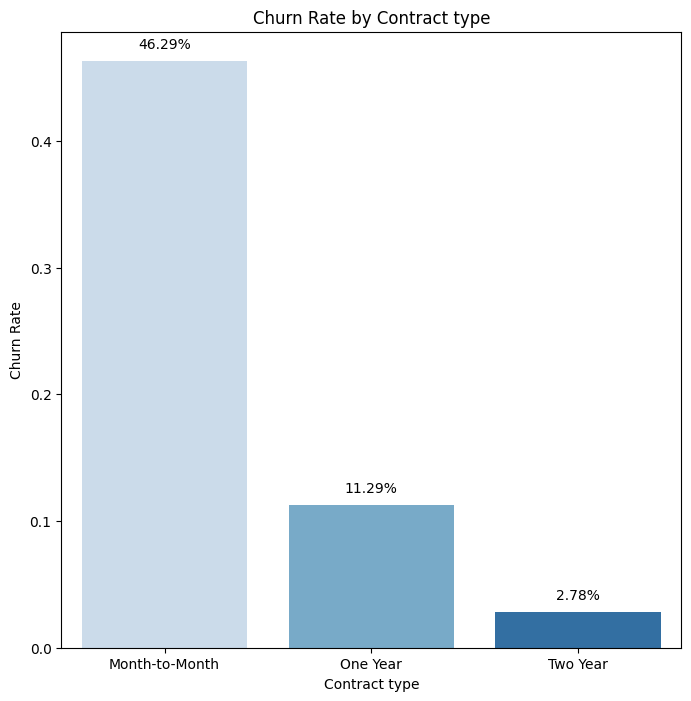

In [ ]:
churn_rate_by_ct = df.groupby('Contract Type')['Churn Label'].value_counts(normalize=True).unstack().fillna(0)
churn_rate_by_ct['Churn Rate'] = churn_rate_by_ct['Yes']

plt.figure(figsize=(8, 8))
sns.barplot(x=churn_rate_by_ct.index, y=churn_rate_by_ct['Churn Rate'], palette='Blues')

for index, value in enumerate(churn_rate_by_ct['Churn Rate']):
    plt.text(index, value + 0.01, f"{value:.2%}", ha='center', fontsize=10)

plt.title('Churn Rate by Contract type')
plt.xlabel('Contract type')
plt.ylabel('Churn Rate')
plt.show()

<ipython-input-32-b8fa383065fe>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_data = df.groupby('Age Group').agg(


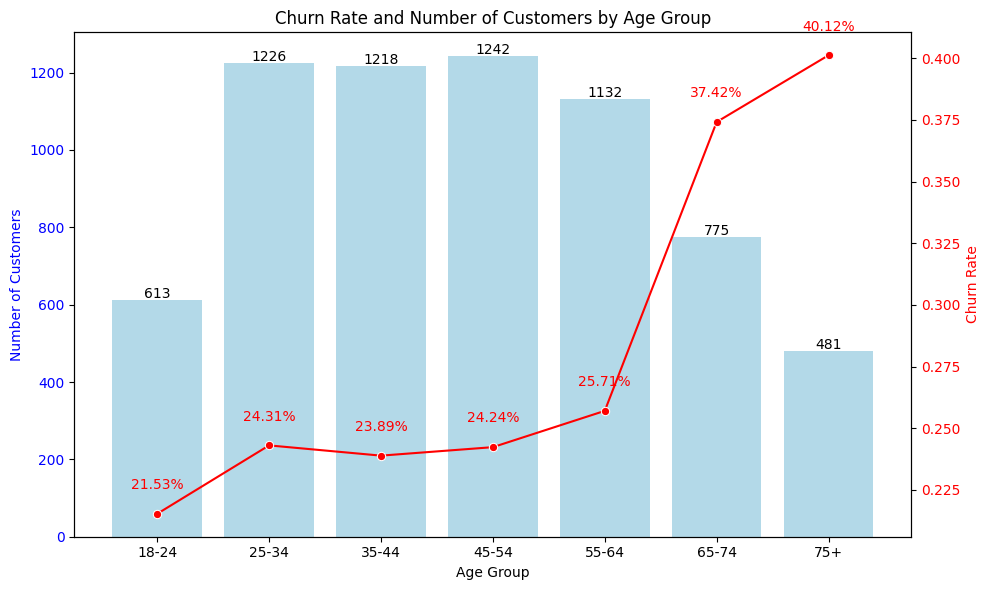

In [ ]:
bins = [18, 25, 35, 45, 55, 65, 75, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

age_group_data = df.groupby('Age Group').agg(
    churn_rate=('Churn Label', lambda x: (x == 'Yes').mean()),
    customer_count=('Age', 'size')
).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(
    x='Age Group',
    y='customer_count',
    data=age_group_data,
    color='skyblue',
    alpha=0.7,
    ax=ax1
)
ax1.set_ylabel('Number of Customers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
sns.lineplot(
    x='Age Group',
    y='churn_rate',
    data=age_group_data,
    marker='o',
    color='red',
    ax=ax2
)
ax2.set_ylabel('Churn Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for index, row in age_group_data.iterrows():
    ax1.text(index, row['customer_count'] + 5, f"{row['customer_count']}", ha='center', fontsize=10)

for index, row in age_group_data.iterrows():
    ax2.text(index, row['churn_rate'] + 0.01, f"{row['churn_rate']:.2%}", ha='center', color='red', fontsize=10)

plt.title('Churn Rate and Number of Customers by Age Group')
plt.xlabel('Age Group')
plt.tight_layout()
plt.show()

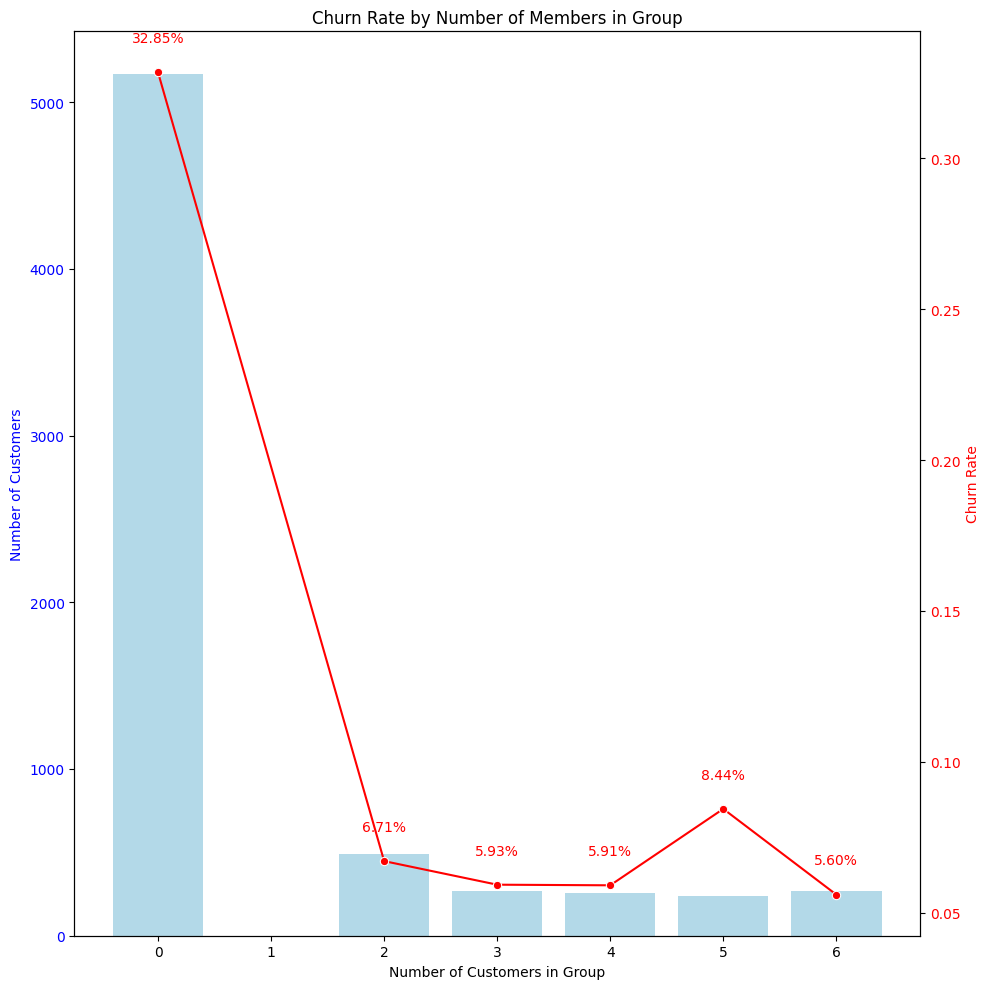

In [ ]:
group_data = df.groupby('Number of Customers in Group').agg(
    churn_rate=('Churn Label', lambda x: (x == 'Yes').mean()),
    customer_count=('Churn Label', 'size')
).reset_index()

group_data = pd.concat([
    group_data,
    pd.DataFrame({'Number of Customers in Group': [1], 'churn_rate': [np.nan], 'customer_count': [0]})
], ignore_index=True)

group_data = group_data.sort_values(by='Number of Customers in Group').reset_index()

fig, ax1 = plt.subplots(figsize=(10, 10))

sns.barplot(
    x='Number of Customers in Group',
    y='customer_count',
    data=group_data,
    color='skyblue',
    alpha=0.7,
    ax=ax1
)
ax1.set_ylabel('Number of Customers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
sns.lineplot(
    x='Number of Customers in Group',
    y='churn_rate',
    data=group_data,
    marker='o',
    color='red',
    ax=ax2
)
ax2.set_ylabel('Churn Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for index, row in group_data.iterrows():
    ax2.text(index, row['churn_rate']+0.01, f"{row['churn_rate']:.2%}",
             ha='center', fontsize=10, color='red')

plt.title('Churn Rate by Number of Members in Group')
plt.xlabel('Number of Members in Group')
plt.tight_layout()
plt.show()

## Define the factors make customer leaving

### Customer services:


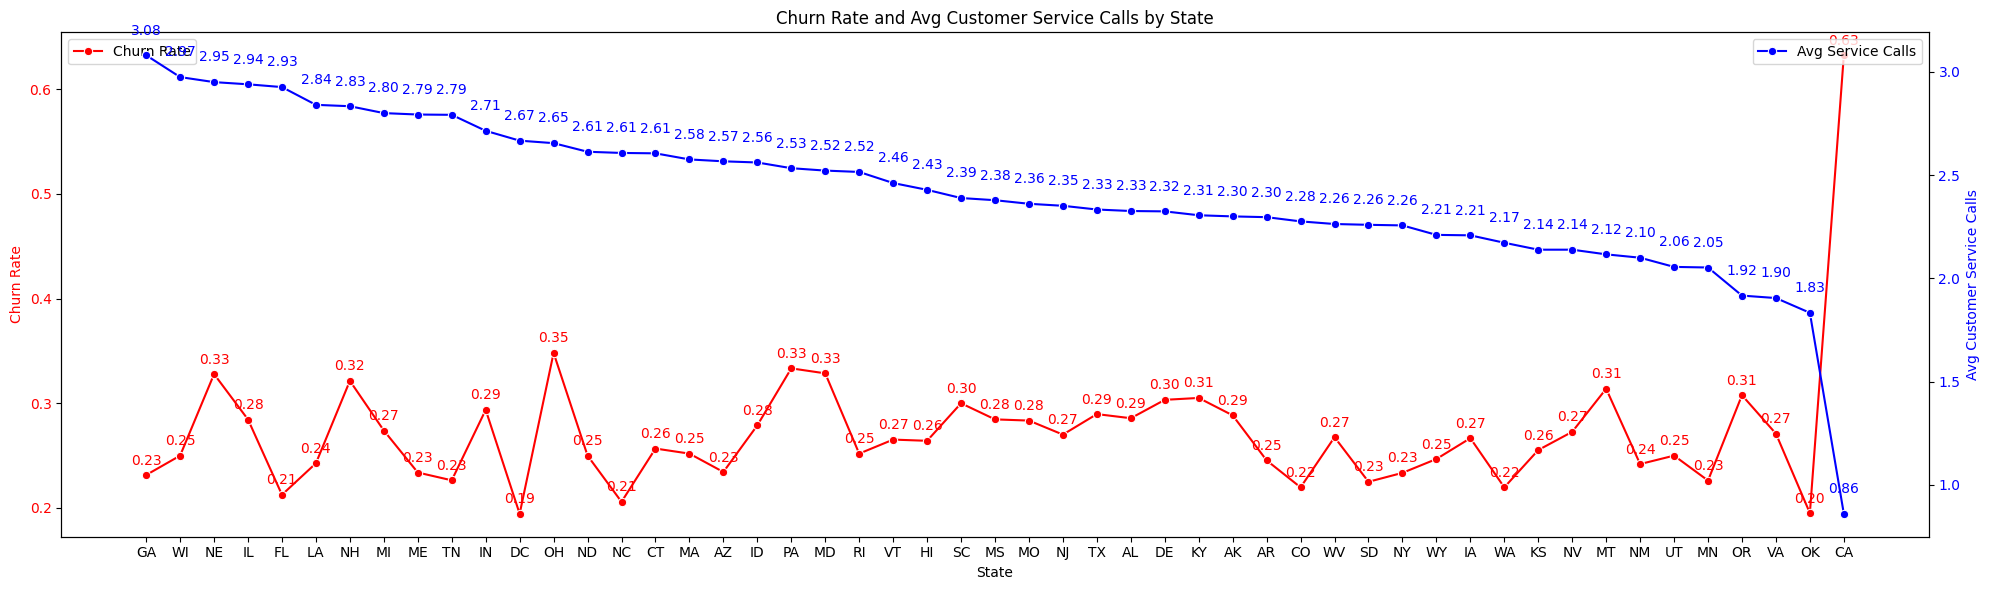

In [ ]:
state_data = df.groupby('State').agg(
    churn_rate=('Churn Label', lambda x: (x == 'Yes').mean()),
    avg_service_calls=('Customer Service Calls', lambda x: x[df.loc[x.index, 'Churn Label'] == 'Yes'].mean())
).reset_index()

state_data = state_data.sort_values(by=['avg_service_calls'], ascending=False)

fig, ax1 = plt.subplots(figsize=(20, 6))

sns.lineplot(
    x='State',
    y='churn_rate',
    data=state_data,
    marker='o',
    color='red',
    ax=ax1,
    label='Churn Rate'
)
ax1.set_ylabel('Churn Rate', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
sns.lineplot(
    x='State',
    y='avg_service_calls',
    data=state_data,
    marker='o',
    color='blue',
    ax=ax2,
    label='Avg Service Calls'
)
ax2.set_ylabel('Avg Customer Service Calls', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

for i, row in state_data.iterrows():
    # Get the x-coordinate from the index of the state in sorted data
    x_pos = state_data.index.get_loc(i)
    ax1.text(x_pos, row['churn_rate'] + 0.01, f"{row['churn_rate']:.2f}",
             ha='center', color='red', fontsize=10)
    ax2.text(x_pos, row['avg_service_calls'] + 0.1, f"{row['avg_service_calls']:.2f}",
             ha='center', color='blue', fontsize=10)

plt.title('Churn Rate and Avg Customer Service Calls by State')
ax1.set_xlabel('State')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

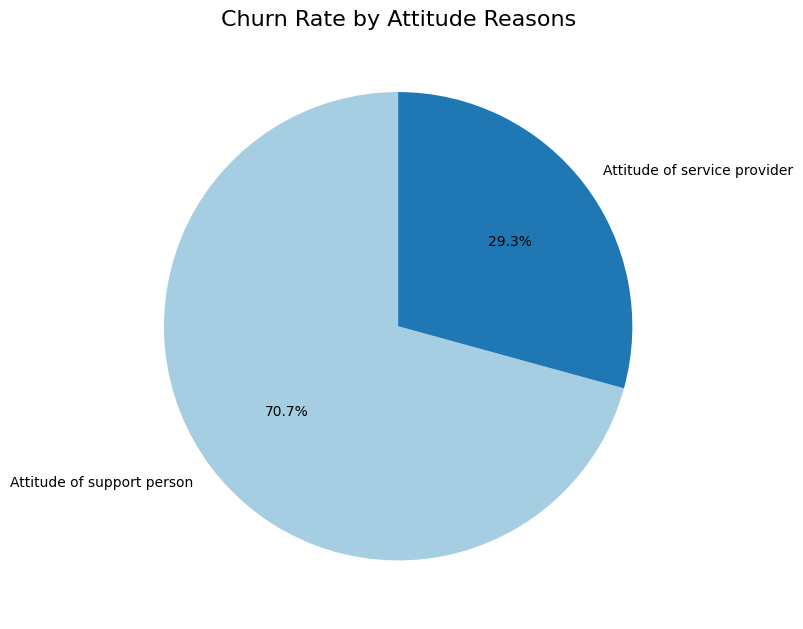

In [ ]:
churn_attitude_data = df[(df['Churn Label'] == 'Yes') & (df['Churn Category'] == 'Attitude')]
churn_reason_counts = churn_attitude_data['Churn Reason'].value_counts()
total_churn_customers_attitude = len(churn_attitude_data)
churn_rate_by_attitude = (churn_reason_counts / total_churn_customers_attitude) * 100

plt.figure(figsize=(8, 8))
plt.pie(
    churn_rate_by_attitude,
    labels=churn_rate_by_attitude.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors
)
plt.title('Churn Rate by Attitude Reasons', fontsize=16)
plt.tight_layout()
plt.show()

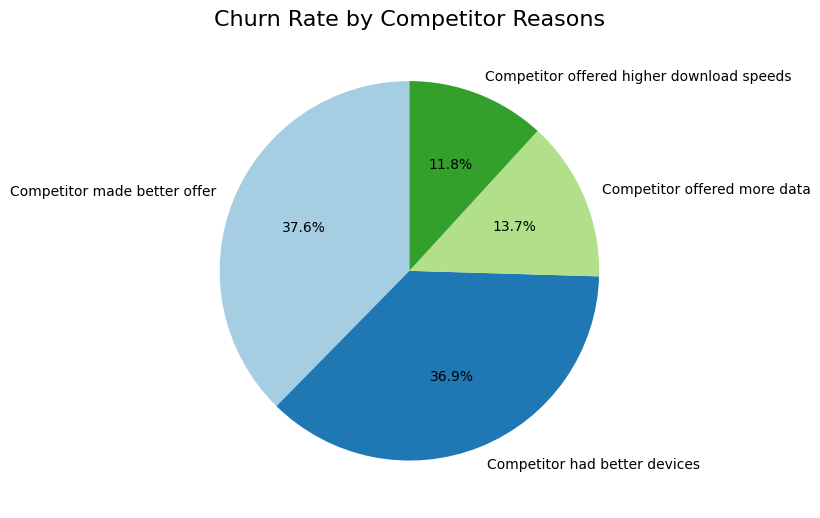

In [ ]:
churn_competitor_data = df[(df['Churn Label'] == 'Yes') & (df['Churn Category'] == 'Competitor')]
churn_reason_counts = churn_competitor_data['Churn Reason'].value_counts()
total_churn_customers_competitor = len(churn_competitor_data)
churn_rate_by_competitor = (churn_reason_counts / total_churn_customers_competitor) * 100

plt.figure(figsize=(8, 8))
plt.pie(
    churn_rate_by_competitor,
    labels=churn_rate_by_competitor.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors
)
plt.title('Churn Rate by Competitor Reasons', fontsize=16)
plt.tight_layout()
plt.show()

<ipython-input-50-fc0c9b4d9aed>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate_data = df.groupby(['Account Length Binned', 'Contract Type']).agg(


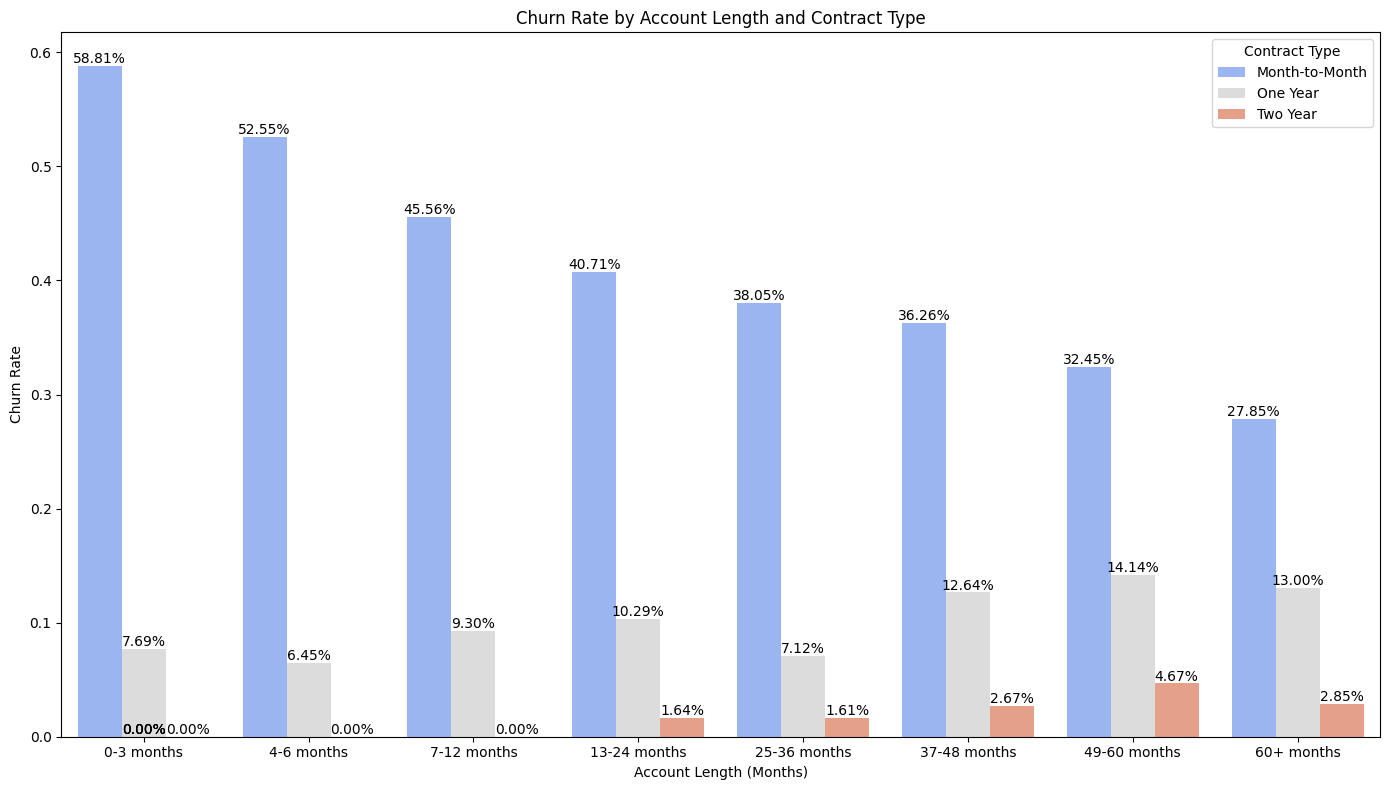

In [ ]:
bin_edges = [0, 3, 6, 12, 24, 36, 48, 60, 100]
bin_labels = ['0-3 months', '4-6 months', '7-12 months', '13-24 months', '25-36 months', '37-48 months', '49-60 months', '60+ months']

df['Account Length Binned'] = pd.cut(df['Account Length (in months)'], bins=bin_edges, labels=bin_labels, right=True)

churn_rate_data = df.groupby(['Account Length Binned', 'Contract Type']).agg(
    churn_rate=('Churn Label', lambda x: (x == 'Yes').mean())
).reset_index()

plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x='Account Length Binned',
    y='churn_rate',
    hue='Contract Type',
    data=churn_rate_data,
    palette='coolwarm'
)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2%}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        fontsize=10, color='black',
        xytext=(0, 5),
        textcoords='offset points'
    )

plt.title('Churn Rate by Account Length and Contract Type')
plt.xlabel('Account Length (Months)')
plt.ylabel('Churn Rate')

plt.tight_layout()
plt.show()

### Extracharges and additional services

In [ ]:
print(f"Average Extra International Charges is: {df['Extra International Charges'].mean():,.2f}$")

Average Extra International Charges is: 33.64$


In [ ]:
print(f"Average Extra Data Charges is: {df['Extra Data Charges'].mean():,.2f}$")

Average Extra Data Charges is: 3.37$


<ipython-input-67-c12520f7b78e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate_by_intl_plan.index, y=churn_rate_by_intl_plan['Churn Rate'], palette='Blues')


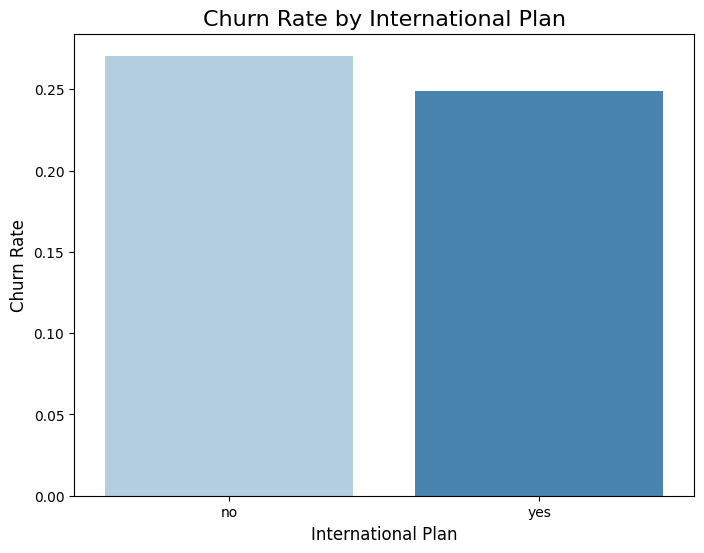

In [ ]:
churn_rate_by_intl_plan = df.groupby('Intl Plan')['Churn Label'].value_counts(normalize=True).unstack().fillna(0)
churn_rate_by_intl_plan['Churn Rate'] = churn_rate_by_intl_plan['Yes']

plt.figure(figsize=(8,6))

sns.barplot(x=churn_rate_by_intl_plan.index, y=churn_rate_by_intl_plan['Churn Rate'], palette='Blues')
plt.title('Churn Rate by International Plan', fontsize=16)
plt.xlabel('International Plan', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.xticks(rotation=0)

for i, v in enumerate(churn_rate_by_intl_plan['Churn Rate']):
    ax.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()


<ipython-input-41-ae1c7d1f1d6f>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate_data = df.groupby(['Avg Monthly GB Download Used Binned', 'Unlimited Data Plan']).agg(


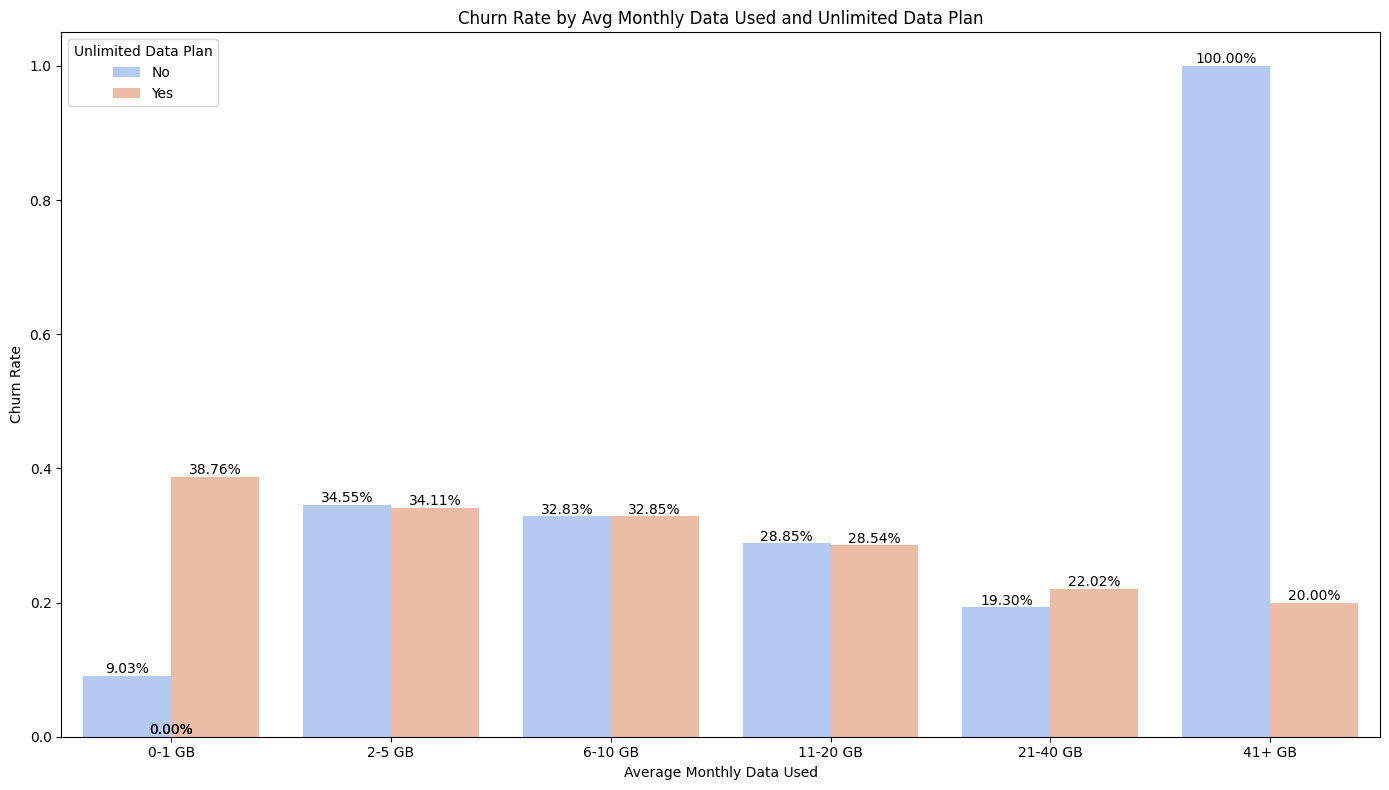

In [ ]:
bin_edges = [-0.01, 1, 5, 10, 20, 40, 1000]
bin_labels = ['0-1 GB', '2-5 GB', '6-10 GB', '11-20 GB', '21-40 GB', '41+ GB']

df['Avg Monthly GB Download Used Binned'] = pd.cut(df['Avg Monthly GB Download'], bins=bin_edges, labels=bin_labels, right=True)

churn_rate_data = df.groupby(['Avg Monthly GB Download Used Binned', 'Unlimited Data Plan']).agg(
    churn_rate=('Churn Label', lambda x: (x == 'Yes').mean())
).reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(
    x='Avg Monthly GB Download Used Binned',
    y='churn_rate',
    hue='Unlimited Data Plan',
    data=churn_rate_data,
    palette='coolwarm'
)

plt.title('Churn Rate by Avg Monthly Data Used and Unlimited Data Plan')
plt.xlabel('Average Monthly Data Used')
plt.ylabel('Churn Rate')

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.01,
             f'{p.get_height():.2%}', ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

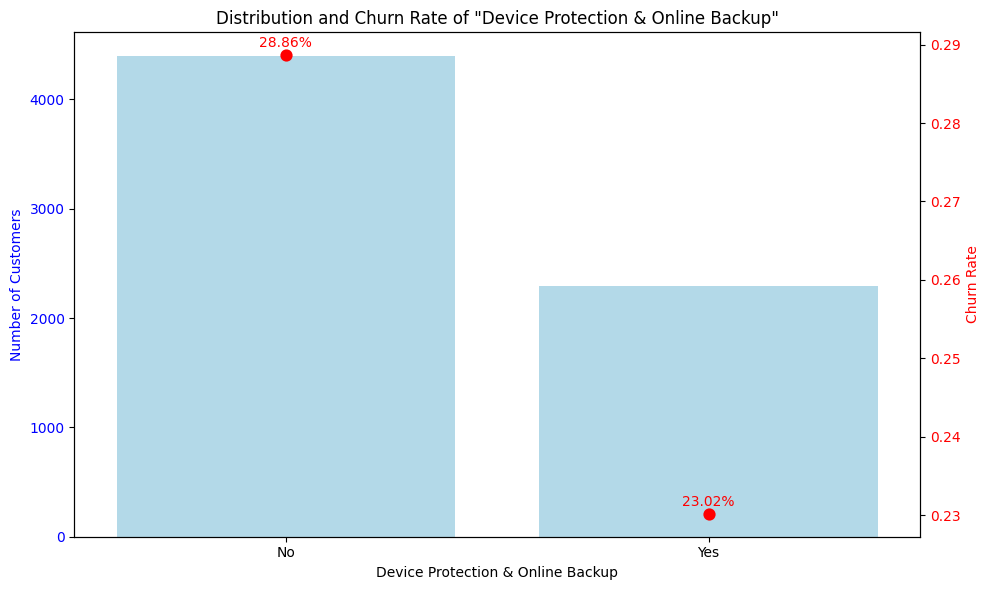

In [ ]:
service_data = df.groupby('Device Protection & Online Backup').agg(
    churn_rate=('Churn Label', lambda x: (x == 'Yes').mean()),
    customer_count=('Churn Label', 'size')
    ).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(
    x='Device Protection & Online Backup',
    y='customer_count',
    data=service_data,
    color='skyblue',
    alpha=0.7,
    ax=ax1
)
ax1.set_ylabel('Number of Customers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
sns.pointplot(
    x='Device Protection & Online Backup',
    y='churn_rate',
    data=service_data,
    marker='o',
    linestyle='',
    color='red',
    ax=ax2
)
ax2.set_ylabel('Churn Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for index, row in service_data.iterrows():
    ax2.text(index, row['churn_rate'] + 0.001,  f"{row['churn_rate']:.2%}", ha='center', fontsize=10, color='red')

plt.title('Distribution and Churn Rate of "Device Protection & Online Backup"')
plt.xlabel('Device Protection & Online Backup')
plt.ylabel('Churn Rate')

plt.tight_layout()
plt.show()

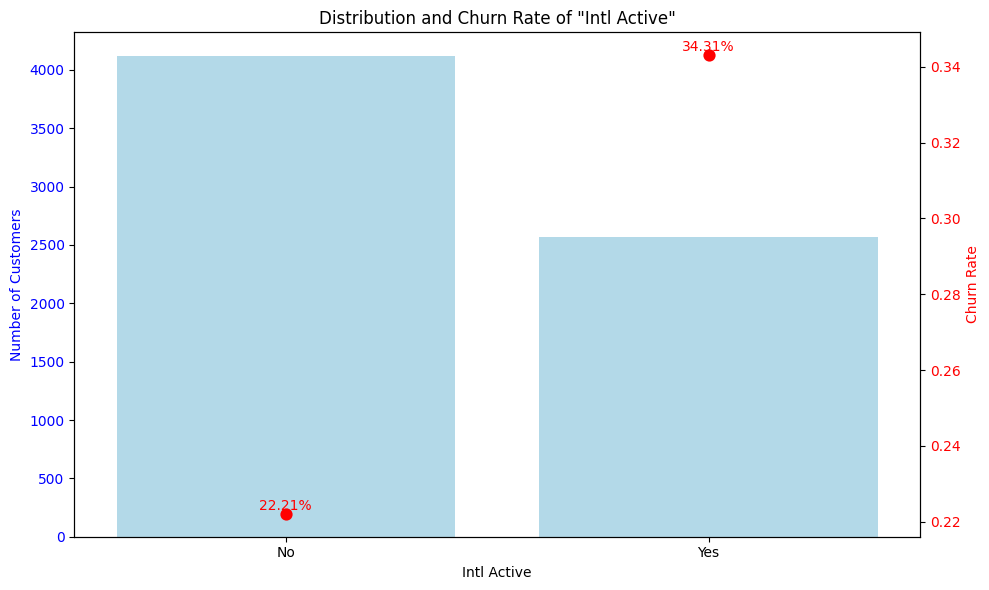

In [ ]:
service_data = df.groupby('Intl Active').agg(
    churn_rate=('Churn Label', lambda x: (x == 'Yes').mean()),
    customer_count=('Churn Label', 'size')
    ).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(
    x='Intl Active',
    y='customer_count',
    data=service_data,
    color='skyblue',
    alpha=0.7,
    ax=ax1
)
ax1.set_ylabel('Number of Customers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
sns.pointplot(
    x='Intl Active',
    y='churn_rate',
    data=service_data,
    marker='o',
    linestyle='',
    color='red',
    ax=ax2
)
ax2.set_ylabel('Churn Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for index, row in service_data.iterrows():
    ax2.text(index, row['churn_rate'] + 0.001,  f"{row['churn_rate']:.2%}", ha='center', fontsize=10, color='red')

plt.title('Distribution and Churn Rate of "Intl Active"')
plt.xlabel('Intl Active')
plt.ylabel('Churn Rate')

plt.tight_layout()
plt.show()

# Building Machine Learning Model

## Features Selection

In [ ]:
categorical_columns = df.select_dtypes(include=['object', 'category', 'bool']).columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
categorical_columns = ['Intl Active', 'Intl Plan',
       'Unlimited Data Plan', 'State', 'Gender', 'Under 30',
       'Senior', 'Group', 'Device Protection & Online Backup', 'Contract Type',
       'Payment Method', 'Age Group',
       'Account Length Binned', 'Avg Monthly GB Download Used Binned']

numerical_columns = ['Account Length (in months)', 'Local Calls', 'Local Mins', 'Intl Calls',
       'Intl Mins', 'Extra International Charges', 'Customer Service Calls',
       'Avg Monthly GB Download', 'Extra Data Charges', 'Age',
       'Number of Customers in Group', 'Monthly Charge', 'Total Charges']

In [ ]:
%%capture --no-stdout
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder

X = df[categorical_columns]
y = df['Churn Label']

X['Age Group'] = X['Age Group'].astype('object')
X['Account Length Binned'] = X['Account Length Binned'].astype('object')
X['Avg Monthly GB Download Used Binned'] = X['Avg Monthly GB Download Used Binned'].astype('object')

for col in categorical_columns:
    X.loc[:, col] = LabelEncoder().fit_transform(X[col])

y_encoded = LabelEncoder().fit_transform(y)

chi2_selector = SelectKBest(score_func=chi2, k=5)
X_selected = chi2_selector.fit_transform(X, y_encoded)

chi2_scores = pd.Series(chi2_selector.scores_, index=X.columns)
print("Chi-square Scores:\n", chi2_scores.sort_values(ascending=False))

selected_categorical_features = X.columns[chi2_selector.get_support()]
print("Selected Features:\n", selected_categorical_features)

Chi-square Scores:
 Contract Type                          1204.278441
Account Length Binned                   774.196533
Group                                   320.614271
Avg Monthly GB Download Used Binned     175.817075
Payment Method                          152.962646
Senior                                   80.678789
Age Group                                79.099013
Intl Active                              72.593456
Unlimited Data Plan                      63.087212
Device Protection & Online Backup        17.232877
Under 30                                  9.755627
State                                     5.265712
Intl Plan                                 1.290392
Gender                                    0.159003
dtype: float64
Selected Features:
 Index(['Group', 'Contract Type', 'Payment Method', 'Account Length Binned',
       'Avg Monthly GB Download Used Binned'],
      dtype='object')


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

X = df[numerical_columns]
y = df['Churn Label']

y_encoded = LabelEncoder().fit_transform(y)

anova_selector = SelectKBest(score_func=f_classif, k=7)
X_selected = anova_selector.fit_transform(X, y_encoded)

anova_scores = pd.Series(anova_selector.scores_, index=X.columns)
print("ANOVA F-test Scores:\n", anova_scores.sort_values(ascending=False))

selected_numerical_features = X.columns[anova_selector.get_support()]
print("Selected Features:\n", selected_numerical_features)

ANOVA F-test Scores:
 Customer Service Calls          4529.593997
Account Length (in months)       942.486178
Local Mins                       636.068808
Local Calls                      578.760583
Number of Customers in Group     360.968056
Monthly Charge                   323.015761
Total Charges                    207.025880
Age                               78.182206
Intl Calls                        57.433976
Intl Mins                         49.107472
Avg Monthly GB Download           10.684517
Extra International Charges        2.595146
Extra Data Charges                 0.182326
dtype: float64
Selected Features:
 Index(['Account Length (in months)', 'Local Calls', 'Local Mins',
       'Customer Service Calls', 'Number of Customers in Group',
       'Monthly Charge', 'Total Charges'],
      dtype='object')


<Axes: >

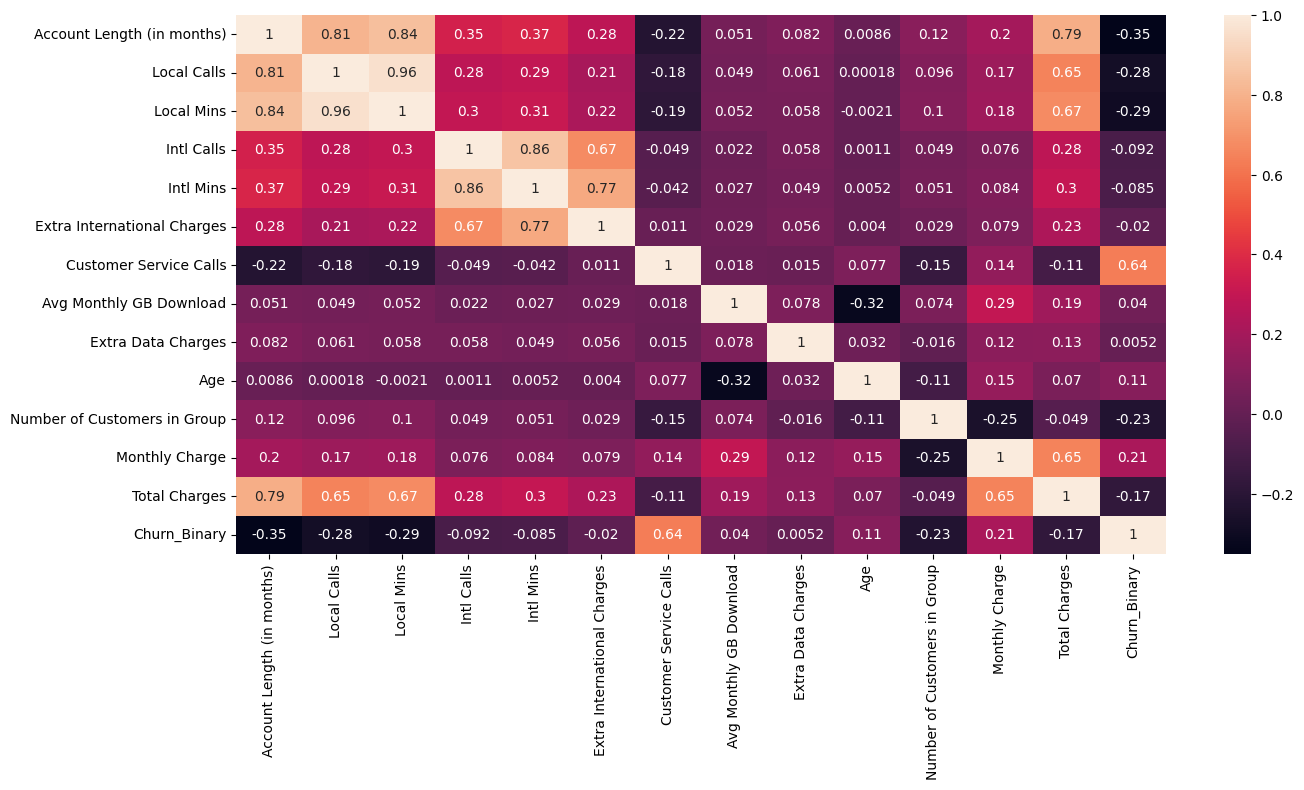

In [ ]:
df_plot = df.copy()
df_plot['Churn_Binary'] = df_plot['Churn Label'].apply(lambda x: 1 if x == 'Yes' else 0)

plt.figure(figsize = (15,7))
sns.heatmap(df_plot.corr(numeric_only=True), annot=True)

## Model Trainning

In [ ]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates a given model on the test data.

    Parameters:
        model: Trained machine learning model.
        X_test: Test feature set.
        y_test: True labels for the test set.

    Returns:
        None. Prints metrics and plots confusion matrix and ROC curve.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_proba)

    print("Evaluation Metrics:")
    print(f"Accuracy:  {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1 Score:  {f1:.2f}")
    print(f"ROC AUC:   {roc_auc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
selected_cols = list(selected_numerical_features) + list(selected_categorical_features)
X = df[selected_cols]
y = df['Churn Label']
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), selected_numerical_features),
        ('cat', OneHotEncoder(), selected_categorical_features)
    ])

### Random Forest

In [ ]:
rf = RandomForestClassifier()

pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("rf", rf)
])

param_grid_rf = {
    'rf__n_estimators': [20, 50, 80, 100, 150, 500],
}

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

grid_search=GridSearchCV(estimator=pipeline, param_grid=param_grid_rf, cv=skf, scoring='f1', verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...............rf__n_estimators=20;, score=0.728 total time=   0.2s
[CV 2/5] END ...............rf__n_estimators=20;, score=0.749 total time=   0.2s
[CV 3/5] END ...............rf__n_estimators=20;, score=0.772 total time=   0.2s
[CV 4/5] END ...............rf__n_estimators=20;, score=0.732 total time=   0.2s
[CV 5/5] END ...............rf__n_estimators=20;, score=0.732 total time=   0.2s
[CV 1/5] END ...............rf__n_estimators=50;, score=0.710 total time=   0.3s
[CV 2/5] END ...............rf__n_estimators=50;, score=0.739 total time=   0.4s
[CV 3/5] END ...............rf__n_estimators=50;, score=0.787 total time=   0.3s
[CV 4/5] END ...............rf__n_estimators=50;, score=0.756 total time=   0.3s
[CV 5/5] END ...............rf__n_estimators=50;, score=0.770 total time=   0.4s
[CV 1/5] END ...............rf__n_estimators=80;, score=0.720 total time=   0.5s
[CV 2/5] END ...............rf__n_estimators=80;,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         Index(['Account Length (in months)', 'Local Calls', 'Local Mins',
       'Customer Service Calls', 'Number of Customers in Group',
       'Monthly Charge', 'Total Charges'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         Index(['Group', 'Contract Type', 'Payment Method', 'Account Length Binned',
       'Avg Monthly GB Download Used Binned'],
      dtype='object'))])),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__n_estimators': [20, 50, 80, 100, 150, 500]},
             scoring='f1', verbose=3)

In [ ]:
grid_search.best_params_

{'rf__n_estimators': 150}

In [ ]:
best_model = grid_search.best_estimator_
print(best_model)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['Account Length (in months)', 'Local Calls', 'Local Mins',
       'Customer Service Calls', 'Number of Customers in Group',
       'Monthly Charge', 'Total Charges'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['Group', 'Contract Type', 'Payment Method', 'Account Length Binned',
       'Avg Monthly GB Download Used Binned'],
      dtype='object'))])),
                ('rf', RandomForestClassifier(n_estimators=150))])


Evaluation Metrics:
Accuracy:  0.89
Precision: 0.84
Recall:    0.74
F1 Score:  0.78
ROC AUC:   0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       979
           1       0.84      0.74      0.78       359

    accuracy                           0.89      1338
   macro avg       0.87      0.84      0.86      1338
weighted avg       0.89      0.89      0.89      1338



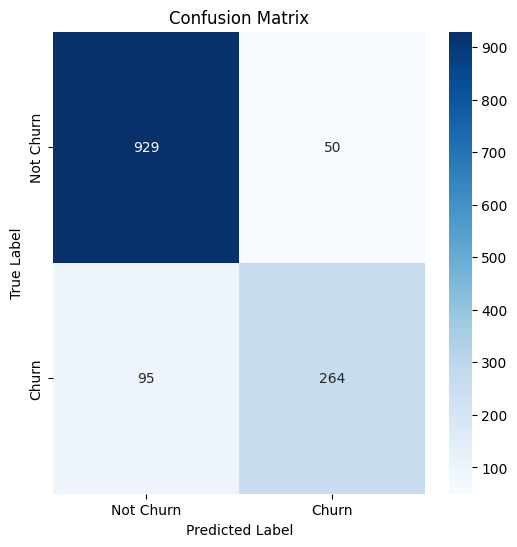

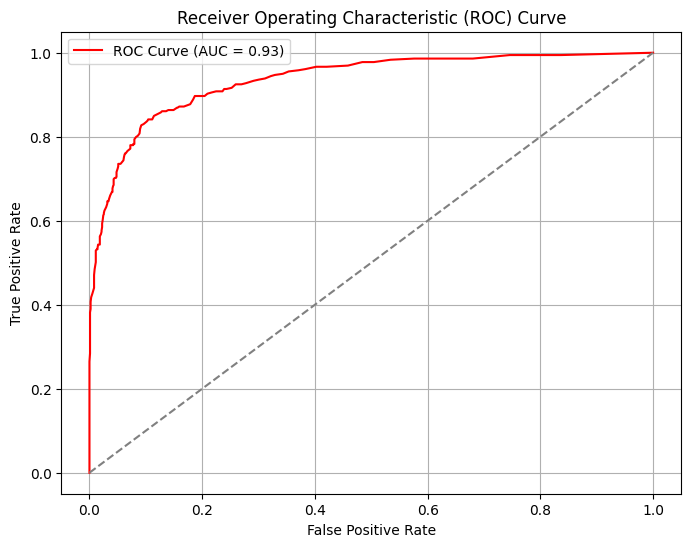

In [ ]:
evaluate_model(best_model, X_test, y_test)

In [ ]:
filename = '/content/drive/MyDrive/CHURN PROJECT/churn_model_rfr_f1.sav'
joblib.dump(best_model, filename)

['/content/drive/MyDrive/CHURN PROJECT/churn_model_rfr_f1.sav']

### XGBOOST

In [ ]:
xgb = XGBClassifier(eval_metric='logloss')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb)
])

param_grid_xgb = {
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'xgb__n_estimators': [100, 200, 500],
    'xgb__max_depth': [3, 5, 6, 8],
    'xgb__subsample': [0.7, 0.8, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0]
}

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

grid_search=GridSearchCV(estimator=pipeline, param_grid=param_grid_xgb, cv=skf, scoring='f1', verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
best_model = grid_search.best_estimator_
print(best_model)

Evaluation Metrics:
Accuracy:  0.90
Precision: 0.85
Recall:    0.77
F1 Score:  0.81
ROC AUC:   0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       979
           1       0.85      0.77      0.81       359

    accuracy                           0.90      1338
   macro avg       0.88      0.86      0.87      1338
weighted avg       0.90      0.90      0.90      1338



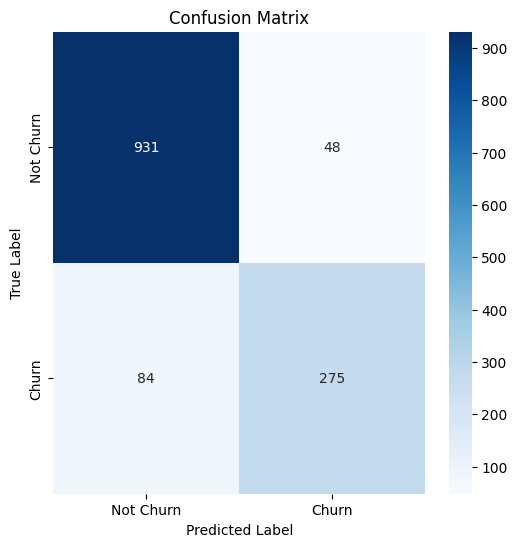

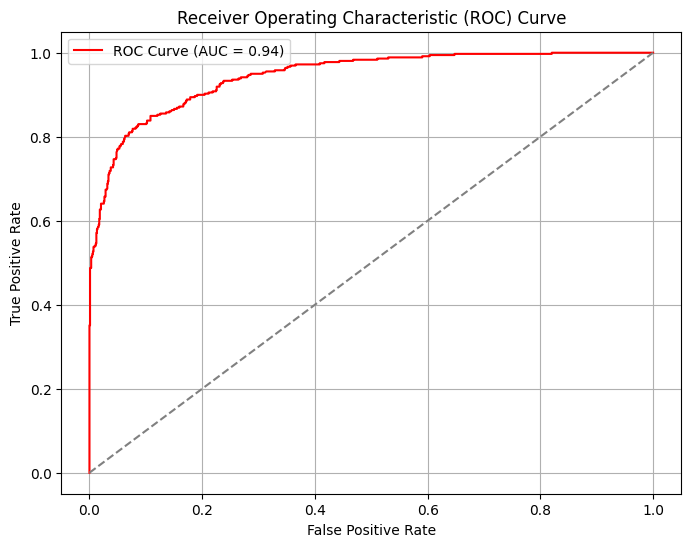

In [ ]:
evaluate_model(best_model, X_test, y_test)

In [ ]:
filename = '/content/drive/MyDrive/CHURN PROJECT/churn_model_xgb_f1.sav'
joblib.dump(best_model, filename)

In [ ]:
best_model = joblib.load('/content/drive/MyDrive/CHURN PROJECT/churn_model_xgb_f1.sav')